In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43466 instead
  f"Port {expected} is already in use.\n"


In [4]:
client.cluster

### Some custom functions

In [5]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [6]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [7]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    return ds
    

In [8]:
def gmean(da,la,cf=1):
    #global mean
    xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    return xg


In [9]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

### Start here
 - load and examine the ensemble

In [10]:
%%time
dvs = ['TLAI']
ds = get_ds(dvs,'h0',1850,2014)

CPU times: user 3min 27s, sys: 5.83 s, total: 3min 33s
Wall time: 7min 51s


In [11]:
# explore global mean LAI (1850-2014)
lai_gm = gmean(ds.TLAI,ds.la).compute()

Text(0, 0.5, 'global mean LAI - defaultCLM')

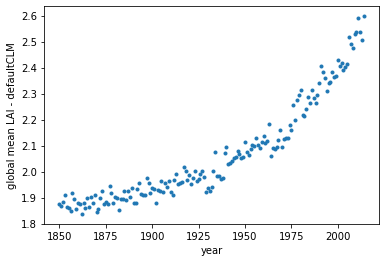

In [12]:
lai_gm_peak = lai_gm.groupby('time.year').max()
lai_gm_peak[0,:].plot.line('.')
plt.ylabel('global mean LAI - defaultCLM')

Text(0, 0.5, 'peak LAI')

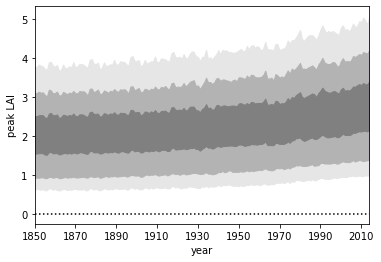

In [25]:
t=1850+np.arange(165)

qs=[1,5,25]
cs=[0.9,0.7,0.5]
for q,c in zip(qs,cs):
    q1 = lai_gm_peak.quantile(q/100,dim='ens')
    q2 = lai_gm_peak.quantile(1-q/100,dim='ens')
    plt.fill_between(t,q1,q2,color=c*np.ones(3),label=q)
plt.xlim([1850,2014])
#plt.ylim([-200,50])

plt.plot(t,np.zeros(165),'k:')
plt.xlabel('year')
plt.xticks(1850+20*np.arange(9))
plt.ylabel('peak LAI')
#plt.savefig('lhc_nbp.png',dpi=500)

In [13]:
# explore default CLM at one gridcell
ds_def_100 = ds.TLAI[0,:,100].compute()

In [14]:
peak = ds_def_100.groupby('time.year').max()
amp = peak - ds_def_100.groupby('time.year').min()

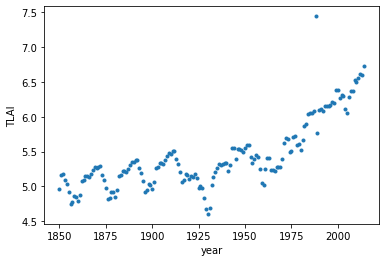

In [15]:
peak.plot.line('.')

In [16]:
# explore ensemble at one gridcell
ds_200 = ds.TLAI[:,:,200].compute() # one grid cell 

In [17]:
peak = ds_200.groupby('time.year').max()
amp = peak - ds_200.groupby('time.year').min()

In [18]:
peak2014 = peak.isel(year=9).compute() # 2014 only

In [19]:
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)

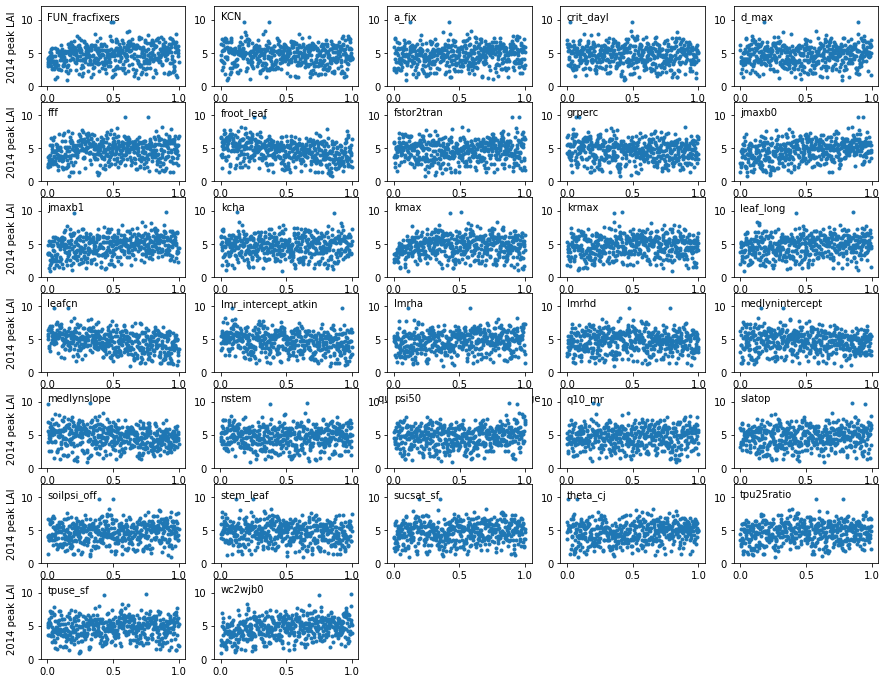

In [28]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],peak2014[1:],'.')
    plt.ylim([0,12])
    plt.text(0,10,p)
    if i%5==0:
        plt.ylabel('2014 peak LAI')
    if i==17:
        plt.xlabel('quantile within parameter range')

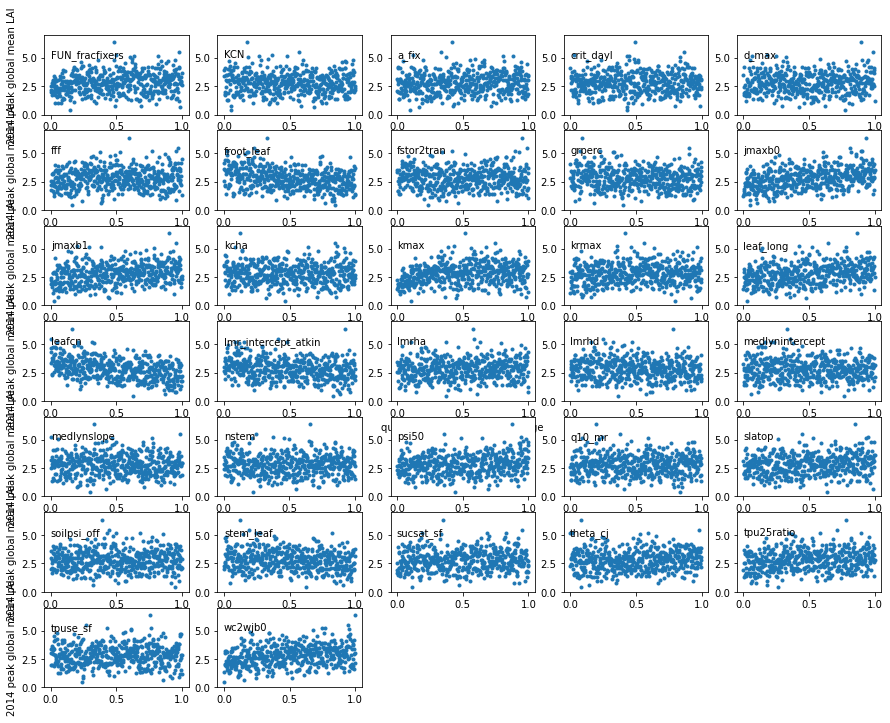

In [29]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],lai_gm_peak[1:,-1],'.')
    plt.ylim([0,7])
    plt.text(0,5,p)
    if i%5==0:
        plt.ylabel('2014 peak global mean LAI')
    if i==17:
        plt.xlabel('quantile within parameter range')

In [30]:
present=gmean(ds.TLAI.sel(time=slice('2005','2014')).mean(dim='time'),ds.la)
past = gmean(ds.TLAI.sel(time=slice('1850','1859')).mean(dim='time'),ds.la)

In [31]:
deltaLAI = present-past
np.shape(deltaLAI)

(501,)

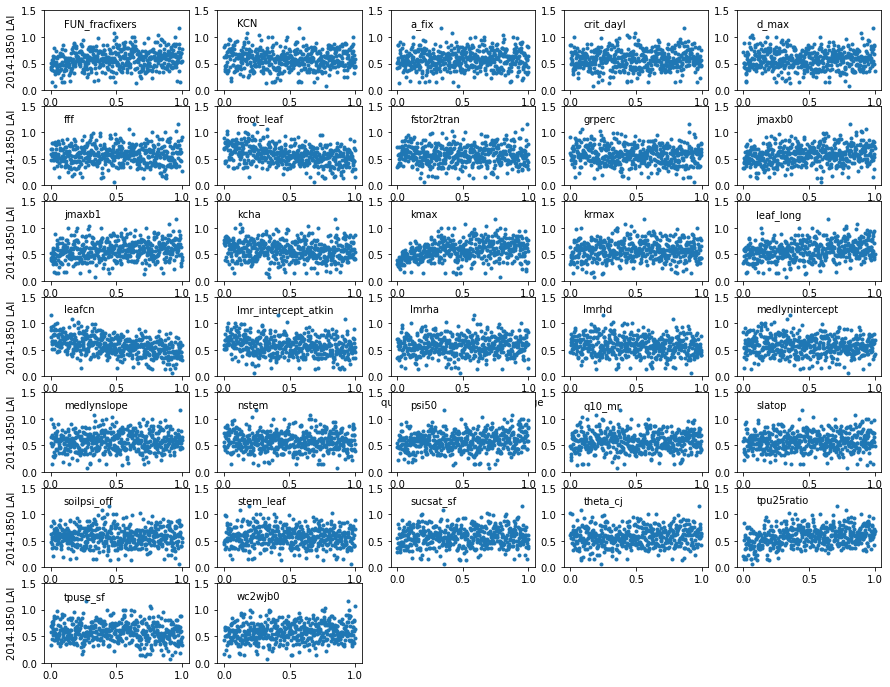

In [33]:
plt.figure(figsize=[15,12])
for i,p in enumerate(df.columns[1:]):
    plt.subplot(7,5,i+1)
    plt.plot(df[p],deltaLAI[1:],'.')
    plt.ylim([0,1.5])
    plt.text(0.1,1.2,p)
    if i%5==0:
        plt.ylabel('2014-1850 LAI')
    if i==17:
        plt.xlabel('quantile within parameter range')